In [6]:
import os
import rf
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from math import ceil
import numpy as np
import pandas as pd
import seaborn as sns

from seismic.receiver_fn.rf_corrections import apply_reverberation_filter


In [3]:
try:
    dataroot = os.environ["DATADIR"]
except KeyError:
    dataroot = os.path.join("data", "processed")
try:
    run = os.environ['RUN']
except KeyError:
    print("Using latest run")
    run = max(
        [
            os.path.join(dataroot, d)
            for d in os.listdir(dataroot)
            if os.path.isdir(os.path.join(dataroot, d))
        ],
        key=os.path.getmtime,
    )
stacks = rf.read_rf(os.path.join(run, "rfstacks.h5"), format='h5').sort(["delay","network", "station"])
reverb_filter_stacks = apply_reverberation_filter(stacks)

Using latest run


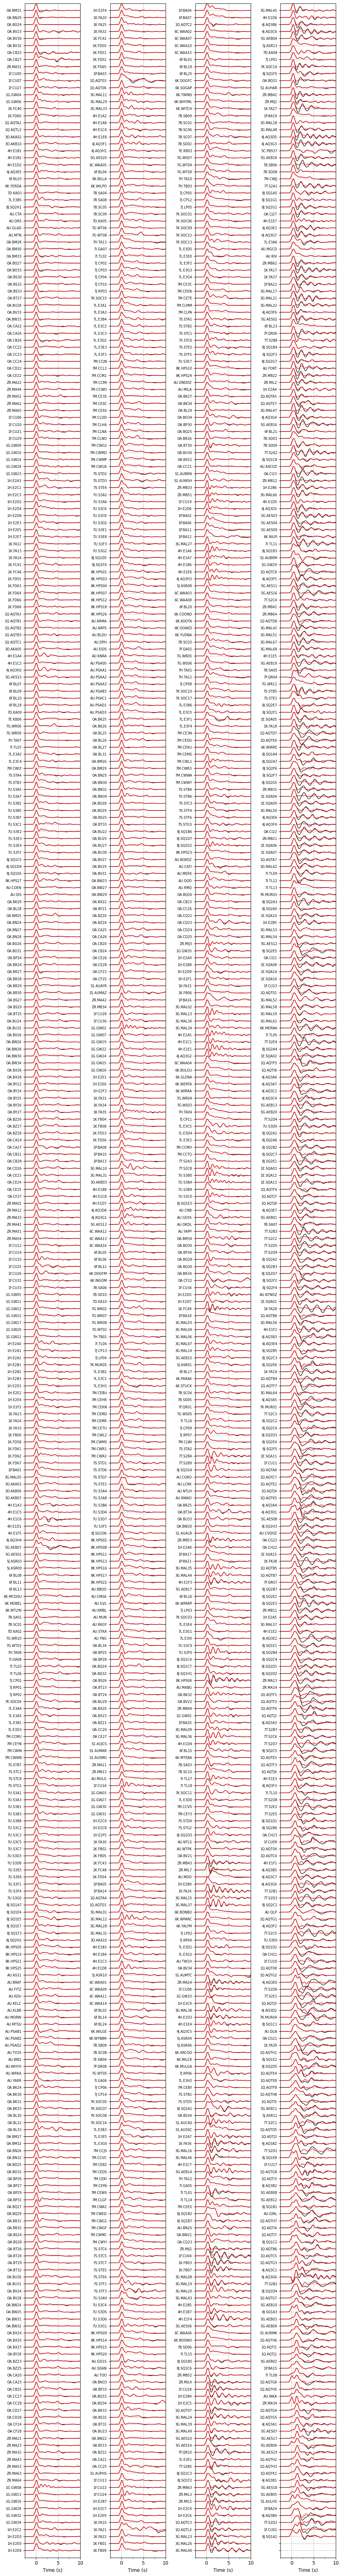

In [4]:
delays = [trace.stats.delay for trace in stacks]
nstacks = len(stacks)
ncols = 4
stacks_per_column = ceil(nstacks / ncols)

stack_height = 0.2
column_height = stack_height * stacks_per_column
fig, axs = plt.subplots(1, ncols, figsize=(10, column_height + 2), tight_layout=True)
for j, ax in enumerate(axs):
    i = 0
    column_stations = []
    while i < stacks_per_column:
        try:
            stack = stacks[j * stacks_per_column + i]
            rv_stack = reverb_filter_stacks[j * stacks_per_column + i]
            assert stack.id == rv_stack.id, f"Stack id {stack.id} does not match that from reverb_filter_stack {rv_stack.id}"
        except IndexError:
            # plot nothing so that what is plotted doesn't get stretched along y
            ax.plot(times, data + i, alpha=0)
            i += 1
            continue
        for _stack, style in zip([stack, rv_stack], ["k", "r"]):
            times = _stack.times() - _stack.stats.onset.second
            data = _stack.data
            data /= data.max()
            level = stacks_per_column - 1 - i
            ax.plot(times, data + level, style, lw=1)
        column_stations.append(".".join([_stack.meta.network, _stack.meta.station]))
        i += 1
    while i:
        try:
            ax.set_yticks(np.arange(stacks_per_column - 1, stacks_per_column - 1 - i, -1))
            ax.set_yticklabels(column_stations, fontsize="x-small", horizontalalignment="right")
        except ValueError:  # i != len(column_stations) 
            i -= 1
        else:
            break

for ax in axs:
    ax.xaxis.set_minor_locator(MultipleLocator(2.5))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.set_xlim([-2.5, 10])
    ax.set_ylim([-1, stacks_per_column])
    ax.grid(True, ls="--")
    ax.set_xlabel("Time (s)")


In [7]:
df = pd.read_csv(os.path.join(run, "delays.txt"), names=("Network", "Station", "Longitude", "Latitude", "TPsb"), sep="\s+")
df.set_index("Station", inplace=True)
Dts = pd.Series([_stack.stats.t3_offset for _stack in reverb_filter_stacks], [_stack.stats.station for _stack in reverb_filter_stacks])
df["Dt"] = Dts
df.head()

Network   Longitude   Latitude  TPsb    Dt
Station                                           
BM31         OA  129.993058 -22.995938   0.0  1.18
BN29         OA  130.496421 -22.006397   0.0  1.08
BO24         OA  130.997155 -19.507225   0.0  2.82
BV23         OA  134.479800 -19.018600   0.0  5.16
BV30         OA  134.462000 -22.494000   0.0  1.20

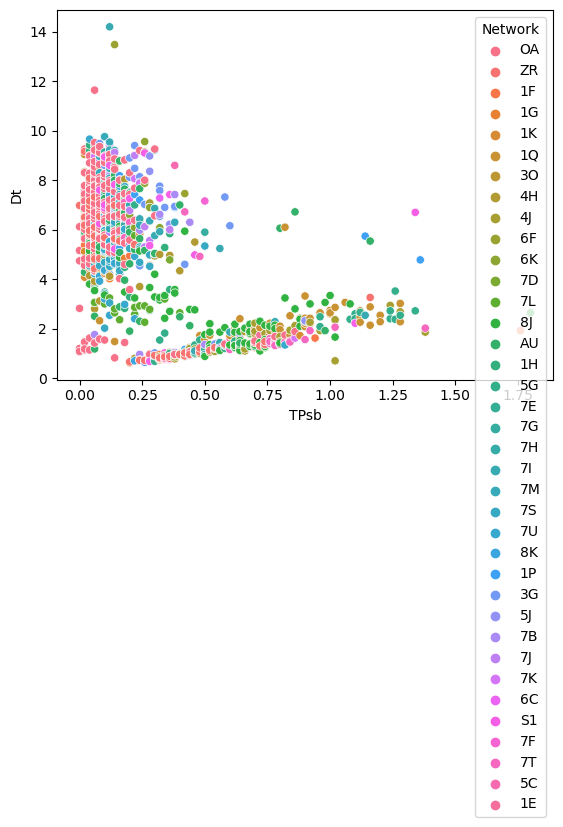

In [10]:
sns.scatterplot(df, x="TPsb", y="Dt", hue="Network")